<a href="https://colab.research.google.com/github/folga67/data_mining/blob/master/OFedorova_hw_les5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [94]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_lesson5/churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [97]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [98]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [99]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [100]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [101]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [103]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standart', StandardScaler())
            ])    
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [104]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [105]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [106]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [107]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [108]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [109]:

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.654, Recall=0.629


In [110]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7749371188027854
log loss score: 0.42548623037651323


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

Отрисуем матрицу ошибок

In [111]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


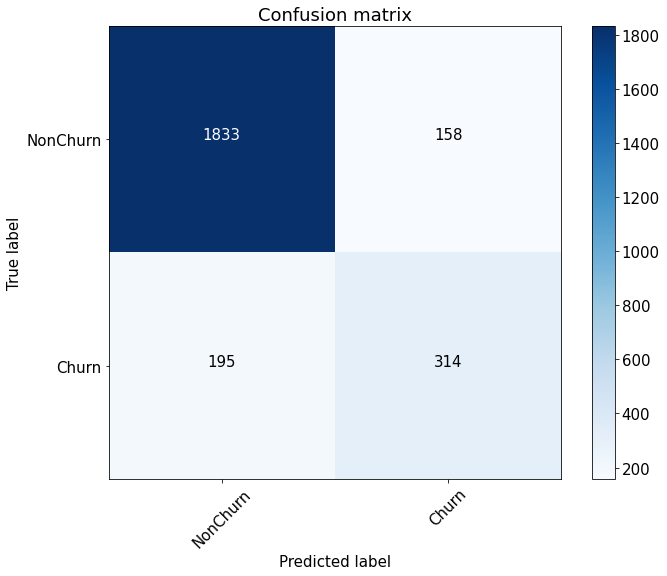

In [112]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


In [113]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Оценка экономической эффективности

In [114]:
profit_RF = TP*2-(TP+FP)*1
profit_RF

156

In [117]:
## Запомним все метрики модели
RandomForest_model = ['RandomForest', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_RF]

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [22]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [23]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

Обучаем модель уже сновыми параметрами

In [118]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.389431, F-Score=0.655, Precision=0.661, Recall=0.648
Confusion matrix, without normalization
[[1822  169]
 [ 180  329]]


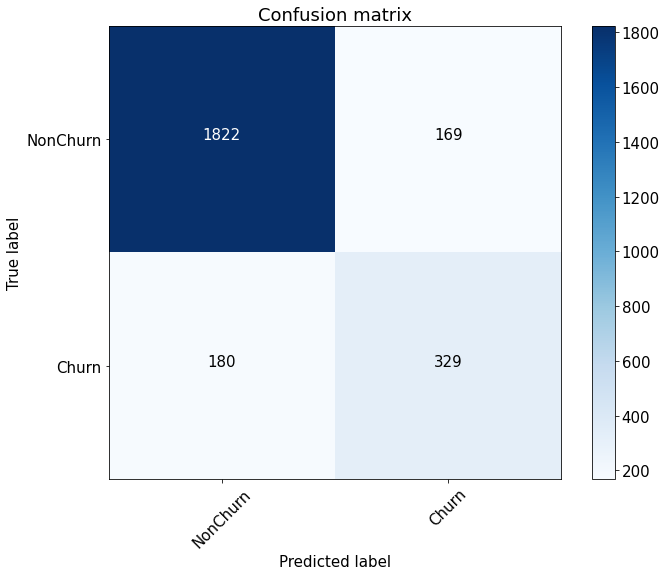

In [119]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [120]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [121]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7749371188027854
log loss score: 0.42548623037651323


In [122]:
profit_RF_search= TP*2-(TP+FP)*1
profit_RF_search

160

In [123]:
RandomForest_model_search = ['RandomForest_search', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_RF_search]

Домашнее задание

In [124]:
## GradientBoostingClassifier(random_state = 42)
classifier = Pipeline([
('features',feats),
('classifier',  GradientBoostingClassifier(random_state = 42))])

classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


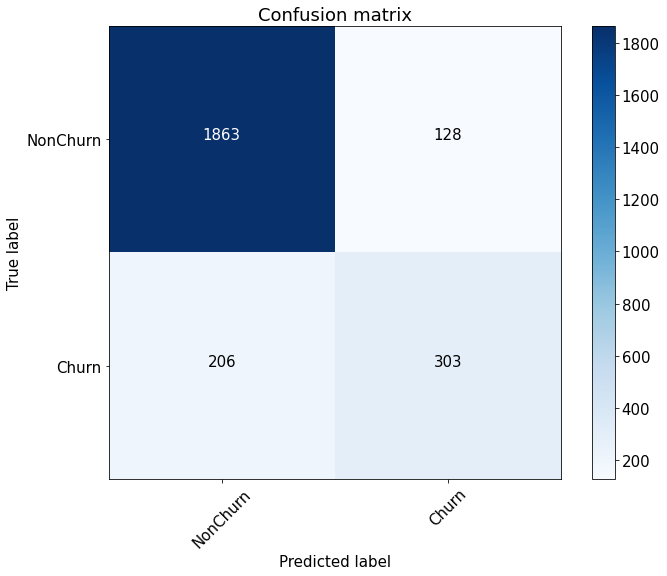

In [125]:
preds = classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [126]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [127]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.8757458662211781
log loss score: 0.3237064718033668


Оценка экономического эффекта

In [128]:
##TP*2$ -(TP+FP)*1
profit_GB = TP*2-(TP+FP)*1
profit_GB

175

In [129]:
GradientBoostingClassifier_model = ['GradientBoostingClassifier', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_GB]

Подбор гиперпараметров модели GaradientBoostingClassifier

In [32]:
params={'classifier__max_features':['auto', 'sqrt', 'log2'],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]          
         }

In [33]:
grid = GridSearchCV(classifier,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 2}

In [130]:
## GradientBoostingClassifier(random_state = 42)
classifier = Pipeline([
('features',feats),
('classifier',  GradientBoostingClassifier(random_state = 42, max_depth = None, max_features = 'sqrt', min_samples_leaf = 2))])

classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.102998, F-Score=0.637, Precision=0.649, Recall=0.625
Confusion matrix, without normalization
[[1819  172]
 [ 192  317]]


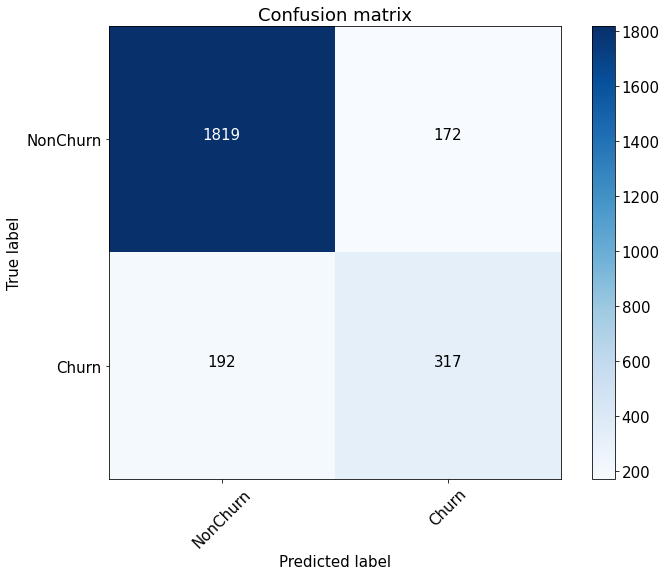

In [131]:
preds = classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [132]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [133]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.8566851420784493
log loss score: 0.6210711186633181


Оценка экономического эффекта

In [134]:
##TP*2$ -(TP+FP)*1
profit_GB_search = TP*2-(TP+FP)*1
profit_GB_search

145

In [135]:
GradientBoostingClassifier_model_search = ['GradientBoostingClassifier_search', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_GB_search]

После подбора гиперпараметров модели, значение ошибки увеличилось и метрика FP увеличилась, а FN уменьшилась, но незначительно. Эффект экономики снизился.

Логистическая регрессия

In [136]:
## LogisticRegression()
classifier = Pipeline([
('features',feats),
('classifier', LogisticRegression(random_state = 42, C = 1, solver = 'lbfgs'))])

classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


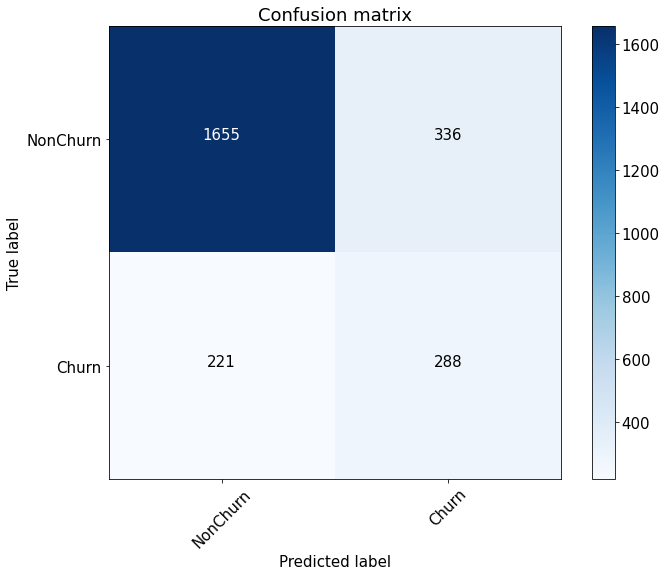

In [137]:
preds = classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [138]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [139]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7720774921330664
log loss score: 0.42677935713450327


Оценка экономического эффектa

In [140]:

profit_LOGR = TP*2-(TP+FP)*1
profit_LOGR

-48

In [141]:
LogisticRegression_model= ['LogisticRegression', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_LOGR]

In [72]:
params = {'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'classifier__C': [1.0, 0.5, 0.1],
          'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'classifier__max_iter' : [100, 500, 1000]
          }

In [73]:
grid = GridSearchCV(classifier,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/skle

{'classifier__C': 0.1,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [142]:
## LogisticRegression() после подбора параметров
classifier = Pipeline([
('features',feats),
('classifier', LogisticRegression(random_state = 42, C = 0.1, solver = 'liblinear', max_iter = 100, penalty = 'l1'))])

classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.290182, F-Score=0.513, Precision=0.465, Recall=0.572
Confusion matrix, without normalization
[[1656  335]
 [ 219  290]]


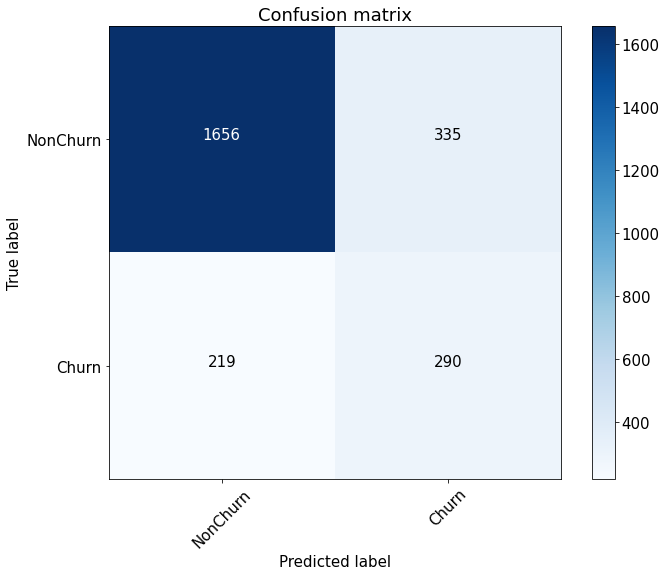

In [143]:
preds = classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [144]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [145]:
## Посмотрим ошибку log_loss для алгоритма градиентного бустинга и roc_auc_score
roc_auc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
logloss= log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7749371188027854
log loss score: 0.42548623037651323


Оценка экономического эффекта

In [146]:
##TP*2$ -(TP+FP)*1
profit_LOGR_search = TP*2-(TP+FP)*1
profit_LOGR_search

-45

In [147]:
LogisticRegression_model_search= ['LogisticRegression_search', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss, TN, FN, TP, FP, profit_LOGR_search]

In [149]:
table_ = pd.DataFrame([RandomForest_model, RandomForest_model_search, GradientBoostingClassifier_model, GradientBoostingClassifier_model_search, LogisticRegression_model, LogisticRegression_model_search], columns = ['model', 'Threshold', 'fscore', 'presicion', 'recall','roc_auc', 'logloss', 'TN', 'FN', 'TP', 'FP', 'Profit']  )

In [153]:
table_.sort_values ('Profit', ascending=False)

,model,Threshold,fscore,presicion,recall,roc_auc,logloss,TN,FN,TP,FP,Profit
2,GradientBoostingClassifier,0.408508,0.646121,0.703704,0.597250,0.875746,0.323706,1863,206,303,128,175
1,RandomForest_search,0.389431,0.654762,0.661323,0.648330,0.774937,0.425486,1822,180,329,169,160
0,RandomForest,0.380000,0.641283,0.654397,0.628684,0.774937,0.425486,1833,195,314,158,156
3,GradientBoostingClassifier_search,0.102998,0.636637,0.648980,0.624754,0.856685,0.621071,1819,192,317,172,145
5,LogisticRegression_search,0.290182,0.512775,0.464856,0.571709,0.774937,0.425486,1656,219,290,335,-45
4,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077,0.426779,1655,221,288,336,-48


По экономической эффективности лучше всех - модель GradientBoostingClassifier с гиперпараметрами алгоритма установленным по умолчанию.
Эта же модель лучшая по DS метрикам: минимальная ошибка logloss - 0.3237, максимальная площадь 'под кривой' - 0.8757

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html